# Lab 5 - Support Vector Machine


Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

**Question 1:** Read the scikit-learn documentation about SVM from here https://scikit-learn.org/stable/modules/svm.html#classification. Make sure that you understand the difference in notation between th course slides and the mathematical formulation of SVM in scikit-learn.


**Question 2:** Follow step by step the next tutorial on SVM. Change the various settings in each block of code in order to observe the differences in the output of the models.

## 1. Support Vector Machine for Classification

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

We will start with the simple case of a classification task, in which the two classes of points are well separated. 

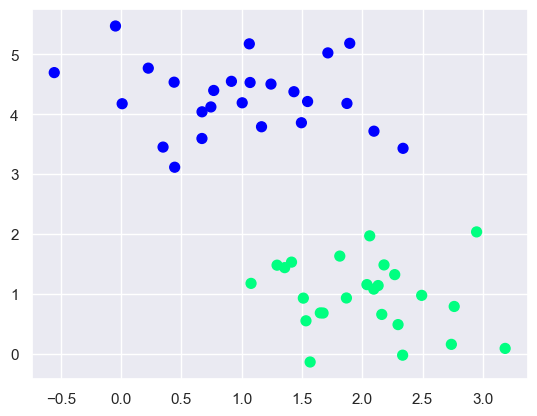

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

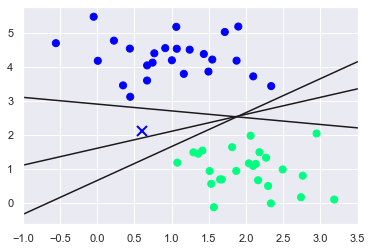

In [3]:
xfit = np.linspace(-1, 3.5) 
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## 2. Support Vector Machines: Maximizing the Margin
Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

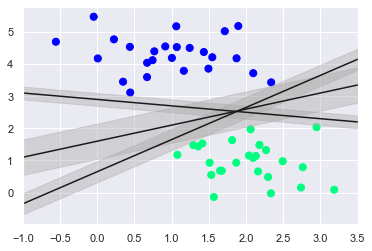

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

### 2.1. Fitting a support vector machine
Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the C parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


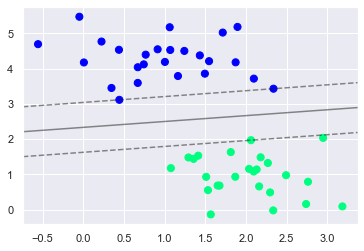

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin in this figure. These points are the pivotal elements of this fit, and are known as the $support$ $vectors$, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

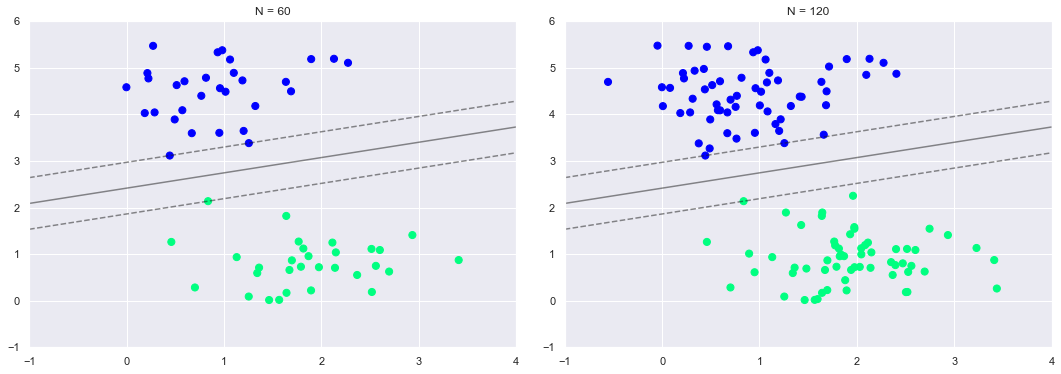

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## 3. Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with kernels. To motivate the need for kernels, let's look at some data that is not linearly separable:

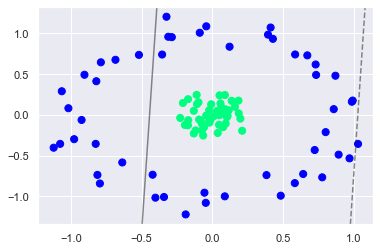

In [12]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. In this case we can think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

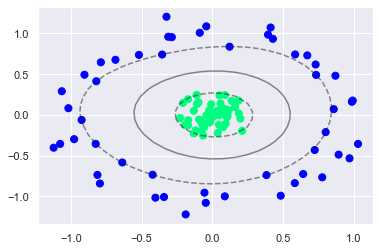

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## 4. Tuning the SVM: Softening Margins
Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap? For example, you may have data like this:

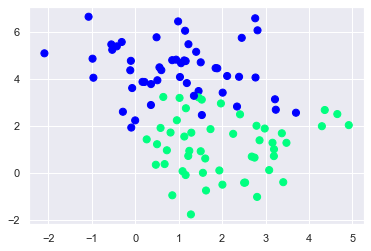

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points. The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

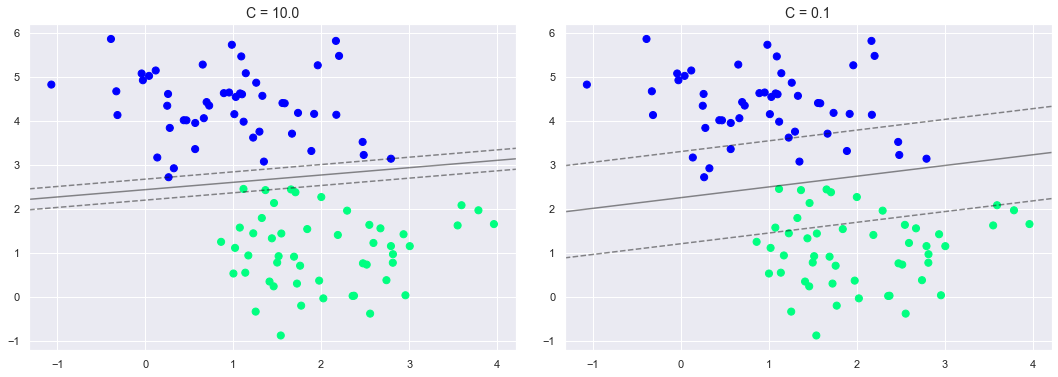

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Your codding start here! 

### Classification
Considering the XOR problem, we have a smal dataset with four points. 

| <b> </b> | <b></b> | <b></b>|
|--|--| --|
| Input 1 | Input 2 | Output |
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 1 | 0 |
| 1 | 0 | 1 |



In [17]:
from sklearn import svm
X = [[0, 0], [0, 1], [1,1], [1,0]]
y = [0, 1, 0, 1]
clf = svm.SVC()
clf.fit(X, y)
SVC()

SVC()

**Question 3:** Which are the support vectors for this dataset?

In [18]:
#Question 3
#.... your answer comes here



**Question 4:** How many support vectors are there for each class? 

In [19]:
#Question 4
#.... your answer comes here



## Multi-class Classification

**Question 5:** In the following code vary the kernel type, gamma, and C to perform multiclass classification. Study the differences between the decision boundaries obtained with various settings of the above mentioned hyper-parameters. For simplicity, we will use just the training data. At the end, it is an example of how the output can look like. Please feel free to make your own choices for the hyper-parameters and your own presentation style of the results. 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def makePlot(models,X,y,titles):

    fig, sub = plt.subplots(9, 4,figsize=(15,30))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    for clf, title, ax in zip(models, titles, sub.flatten()):
    
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

#Questions 5:
# ...Your code comes here.....


